In [263]:
import pandas as pd
import numpy as np
from skimpy import skim
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [146]:
data = pd.read_csv("../data/raw/entsoe.csv")
data_other = pd.read_csv("../data/raw/other.csv")

In [147]:
data.isnull().sum()

Unnamed: 0                                  0
ro_biomass_generation_MW_obs              142
ro_fossilgas_generation_MW_obs            143
ro_fossilhardcoal_generation_MW_obs       127
ro_hydro_reservoir_generation_MW_obs      157
ro_hydro_ror_generation_MW_obs            156
ro_lignite_generation_MW_obs              127
ro_nuclear_generation_MW_obs              142
ro_solar_generation_MW_obs                141
ro_wind_generation_MW_obs                 143
hu_biomass_generation_MW_obs               25
hu_fossilgas_generation_MW_obs             39
hu_fossilhardcoal_generation_MW_obs     43302
hu_geothermal_generation_MW_obs         41640
hu_hydro_ror_generation_MW_obs             25
hu_lignite_generation_MW_obs               25
hu_nuclear_generation_MW_obs               25
hu_other_generation_MW_obs                 25
hu_otherrenewable_generation_MW_obs        25
hu_solar_generation_MW_obs              32856
hu_waste_generation_MW_obs                 25
hu_wind_generation_MW_obs         

In [148]:
data.rename(columns={"Unnamed: 0": "Timestamp"}, inplace=True)

In [149]:
data.head()

,Timestamp,ro_biomass_generation_MW_obs,ro_fossilgas_generation_MW_obs,ro_fossilhardcoal_generation_MW_obs,ro_hydro_reservoir_generation_MW_obs,ro_hydro_ror_generation_MW_obs,ro_lignite_generation_MW_obs,ro_nuclear_generation_MW_obs,ro_solar_generation_MW_obs,ro_wind_generation_MW_obs,...,hu_hydro_ror_generation_MW_obs,hu_lignite_generation_MW_obs,hu_nuclear_generation_MW_obs,hu_other_generation_MW_obs,hu_otherrenewable_generation_MW_obs,hu_solar_generation_MW_obs,hu_waste_generation_MW_obs,hu_wind_generation_MW_obs,hu_total_load_MW_obs,ro_total_load_MW_obs
0,2016-01-01 00:00:00+00:00,45.0,1106.0,192.0,706.0,329.0,1776.0,1402.0,0.0,849.0,...,10.2725,684.1275,1927.5375,95.1,6.9400,NaN,6.0400,73.4775,3974.9650,5981.0
1,2016-01-01 01:00:00+00:00,45.0,1102.0,191.0,595.0,321.0,1628.0,1402.0,0.0,763.0,...,10.3025,726.5350,1925.2425,70.1,4.2375,NaN,5.2650,41.3675,3659.3450,5765.0
2,2016-01-01 02:00:00+00:00,45.0,1099.0,194.0,422.0,341.0,1603.0,1402.0,0.0,714.0,...,10.4775,738.2875,1923.4650,70.1,4.0575,NaN,5.5025,17.5550,3434.6125,5652.0
3,2016-01-01 03:00:00+00:00,45.0,1104.0,192.0,419.0,353.0,1505.0,1402.0,0.0,651.0,...,10.2450,735.4725,1923.8600,71.1,4.0750,NaN,6.1450,4.3450,3372.3375,5592.0
4,2016-01-01 04:00:00+00:00,45.0,1110.0,193.0,403.0,350.0,1573.0,1402.0,0.0,615.0,...,10.2425,743.2225,1923.2550,97.1,5.0625,NaN,6.0950,1.1550,3405.4400,5553.0


Data from Romania and Hungary about different types of production and consumption.
Many missing values but maybe if we aggregate by week it will be better.
24 features, maybe separate the data with 2 tables each by country.

Q1. Using the entsoe dataset provided, reconstruct the “Power Generation Stack” for Romania and
Hungary from 2018 to today. The data must be aggregated weekly. What observations can you
make?

In [150]:
# Split data into Romanian and Hungarian datasets
time_column = "Timestamp"
ro_columns = [time_column] + [column for column in data.columns if column.startswith("ro")]
hu_columns = [time_column] + [column for column in data.columns if column.startswith("hu")]
romanian_data = data[ro_columns].copy()
hungarian_data = data[hu_columns].copy()

In [151]:
romanian_data.isnull().sum()

Timestamp                                  0
ro_biomass_generation_MW_obs             142
ro_fossilgas_generation_MW_obs           143
ro_fossilhardcoal_generation_MW_obs      127
ro_hydro_reservoir_generation_MW_obs     157
ro_hydro_ror_generation_MW_obs           156
ro_lignite_generation_MW_obs             127
ro_nuclear_generation_MW_obs             142
ro_solar_generation_MW_obs               141
ro_wind_generation_MW_obs                143
ro_total_load_MW_obs                    1494
dtype: int64

In [152]:
hungarian_data.isnull().sum()

Timestamp                                  0
hu_biomass_generation_MW_obs              25
hu_fossilgas_generation_MW_obs            39
hu_fossilhardcoal_generation_MW_obs    43302
hu_geothermal_generation_MW_obs        41640
hu_hydro_ror_generation_MW_obs            25
hu_lignite_generation_MW_obs              25
hu_nuclear_generation_MW_obs              25
hu_other_generation_MW_obs                25
hu_otherrenewable_generation_MW_obs       25
hu_solar_generation_MW_obs             32856
hu_waste_generation_MW_obs                25
hu_wind_generation_MW_obs               1561
hu_total_load_MW_obs                      21
dtype: int64

In [154]:
romanian_data["Timestamp"].dtype

dtype('O')

In [155]:
# Convert Timestamp to datetime with UTC timezone in order to avoid warnings
romanian_data["Timestamp"] = pd.to_datetime(romanian_data["Timestamp"], utc=True)
hungarian_data["Timestamp"] = pd.to_datetime(hungarian_data["Timestamp"], utc=True)

In [156]:
romanian_data["Timestamp"].dtype

datetime64[ns, UTC]

In [157]:
romanian_data = romanian_data.set_index("Timestamp")
hungarian_data = hungarian_data.set_index("Timestamp")

In [158]:
# Need for question 3
romanian_data.to_csv("../data/processed_data/romanian_data.csv", index=True)

In [159]:
# Resample to weekly frequency, starting on Mondays, taking the mean
romanian_weekly = romanian_data.resample("W-MON").mean()
hungarian_weekly = hungarian_data.resample("W-MON").mean()

In [160]:
# Aggreate from 2018-01-01
romanian_weekly = romanian_weekly.loc["2018-01-01":]
hungarian_weekly = hungarian_weekly.loc["2018-01-01":]

In [161]:
# Remove country and unit prefixes from columns
romanian_weekly.columns = romanian_weekly.columns.str.replace("ro_", "", regex=False)
hungarian_weekly.columns = hungarian_weekly.columns.str.replace("hu_", "", regex=False)
romanian_weekly.columns = romanian_weekly.columns.str.replace("_MW_obs", "", regex=False)
hungarian_weekly.columns = hungarian_weekly.columns.str.replace("_MW_obs", "", regex=False)

In [162]:
# Round to 2 decimals
romanian_weekly = romanian_weekly.round(2)
hungarian_weekly = hungarian_weekly.round(2)

In [163]:
romanian_weekly.isnull().sum()

biomass_generation           0
fossilgas_generation         0
fossilhardcoal_generation    0
hydreservoir_generation      0
hydror_generation            0
lignite_generation           0
nuclear_generation           0
solar_generation             0
wind_generation              0
total_load                   9
dtype: int64

In [164]:
hungarian_weekly.isnull().sum()

biomass_generation             0
fossilgas_generation           0
fossilhardcoal_generation    144
geothermal_generation        144
hydro_ror_generation           0
lignite_generation             0
nuclear_generation             0
other_generation               0
otherrenewable_generation      0
solar_generation              92
waste_generation               0
wind_generation                0
total_load                     0
dtype: int64

In [165]:
hungarian_weekly[hungarian_weekly["solar_generation"].isna()].head(5)

,biomass_generation,fossilgas_generation,fossilhardcoal_generation,geothermal_generation,hydro_ror_generation,lignite_generation,nuclear_generation,other_generation,otherrenewable_generation,solar_generation,waste_generation,wind_generation,total_load
Timestamp,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,108.68,665.80,NaN,NaN,4.65,468.16,1918.00,89.48,11.62,NaN,12.62,110.48,4313.65
2018-01-08 00:00:00+00:00,94.07,820.40,NaN,NaN,5.36,586.78,1919.38,92.15,11.26,NaN,15.31,77.96,5006.05
2018-01-15 00:00:00+00:00,108.37,1001.98,NaN,NaN,7.50,583.27,1923.58,93.49,11.96,NaN,14.52,51.84,5284.76
2018-01-22 00:00:00+00:00,107.69,964.40,NaN,NaN,13.10,654.53,1872.42,84.98,12.93,NaN,8.68,109.25,5392.76
2018-01-29 00:00:00+00:00,109.17,980.07,NaN,NaN,15.83,620.66,1412.27,87.58,13.33,NaN,8.82,59.68,5346.47


In [166]:
# Find last NaN for selected columns
cols_to_check = [
    "solar_generation",
    "geothermal_generation",
    "fossilhardcoal_generation"
]

last_nan_summary = {
    col: hungarian_weekly[hungarian_weekly[col].isna()].index.max()
    for col in cols_to_check
}

last_nan_df = pd.DataFrame.from_dict(
    last_nan_summary,
    orient="index",
    columns=["last_nan_date"]
)

last_nan_df


,last_nan_date
solar_generation,2019-09-30 00:00:00+00:00
geothermal_generation,2020-09-28 00:00:00+00:00
fossilhardcoal_generation,2020-09-28 00:00:00+00:00


In [167]:
# Replace NaN with 0 for generation sources that were not present
hungarian_weekly = hungarian_weekly.fillna(0)

In [168]:
# Round to 2 decimals
romanian_weekly = romanian_weekly.round(2)
hungarian_weekly = hungarian_weekly.round(2)

In [ ]:
# Prepare data for stacked area plot for Romania and aggregate sources
romanian_stack = pd.DataFrame(index=romanian_weekly.index)

romanian_stack["Fossil"] = (
    romanian_weekly["fossilgas_generation"]
    + romanian_weekly["fossilhardcoal_generation"]
    + romanian_weekly["lignite_generation"]
)

romanian_stack["Nuclear"] = romanian_weekly["nuclear_generation"]

romanian_stack["Hydro"] = (
    romanian_weekly["hydreservoir_generation"]
    + romanian_weekly["hydror_generation"]
)

romanian_stack["Wind"] = romanian_weekly["wind_generation"]
romanian_stack["Solar"] = romanian_weekly["solar_generation"]

romanian_stack["Other renewables"] = romanian_weekly["biomass_generation"]

In [ ]:
# Prepare data for stacked area plot for Hungary and aggregate sources
hungarian_stack = pd.DataFrame(index=hungarian_weekly.index)

hungarian_stack["Fossil"] = (
    hungarian_weekly["fossilgas_generation"]
    + hungarian_weekly["fossilhardcoal_generation"]
    + hungarian_weekly["lignite_generation"]
)

hungarian_stack["Nuclear"] = hungarian_weekly["nuclear_generation"]

hungarian_stack["Hydro"] = hungarian_weekly["hydro_ror_generation"]

hungarian_stack["Wind"] = hungarian_weekly["wind_generation"]
hungarian_stack["Solar"] = hungarian_weekly["solar_generation"]

hungarian_stack["Other renewables"] = (
    hungarian_weekly["biomass_generation"]
    + hungarian_weekly["geothermal_generation"]
    + hungarian_weekly["otherrenewable_generation"]
)

hungarian_stack["Other"] = (
    hungarian_weekly["waste_generation"]
    + hungarian_weekly["other_generation"]
)


In [171]:
romanian_stack.head()

,Fossil,Nuclear,Hydro,Wind,Solar,Other renewables
Timestamp,,,,,,
2018-01-01 00:00:00+00:00,2929.11,1392.18,1674.77,1064.42,63.06,33.76
2018-01-08 00:00:00+00:00,3683.26,1390.00,1705.03,590.68,58.01,35.37
2018-01-15 00:00:00+00:00,3946.51,1396.23,1708.57,1227.62,40.48,54.26
2018-01-22 00:00:00+00:00,3992.98,1382.30,1740.19,1216.67,48.53,55.65
2018-01-29 00:00:00+00:00,4261.15,1396.30,1645.55,636.62,102.32,53.42


In [260]:
romanian_stack.describe()

,Fossil,Nuclear,Hydro,Wind,Solar,Other renewables
count,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000
mean,2332.039165,1265.159356,1782.884368,755.074463,184.967351,52.412506
std,637.108512,222.594146,556.515645,314.397096,104.495525,13.440216
min,714.480000,593.960000,990.860000,96.410000,16.920000,22.100000
25%,1912.680000,1250.850000,1348.735000,503.945000,106.595000,41.580000
50%,2336.820000,1366.890000,1662.800000,724.810000,182.520000,52.480000
75%,2700.415000,1392.340000,2040.160000,961.645000,230.820000,63.510000
max,4261.150000,1421.090000,3610.070000,1908.880000,594.030000,82.280000


In [172]:
hungarian_stack.head()

,Fossil,Nuclear,Hydro,Wind,Solar,Other renewables,Other
Timestamp,,,,,,,
2018-01-01 00:00:00+00:00,1133.96,1918.00,4.65,110.48,0.0,120.30,102.10
2018-01-08 00:00:00+00:00,1407.18,1919.38,5.36,77.96,0.0,105.33,107.46
2018-01-15 00:00:00+00:00,1585.25,1923.58,7.50,51.84,0.0,120.33,108.01
2018-01-22 00:00:00+00:00,1618.93,1872.42,13.10,109.25,0.0,120.62,93.66
2018-01-29 00:00:00+00:00,1600.73,1412.27,15.83,59.68,0.0,122.50,96.40


In [261]:
hungarian_stack.describe() 

,Fossil,Nuclear,Hydro,Wind,Solar,Other renewables,Other
count,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000
mean,1197.528687,1721.770358,10.870788,71.325919,343.570979,130.842005,77.451169
std,329.087227,226.816465,3.702951,36.271027,337.800867,35.352555,16.987356
min,442.770000,950.040000,0.770000,4.910000,0.000000,41.060000,37.870000
25%,940.330000,1457.370000,7.835000,45.835000,51.180000,113.635000,66.160000
50%,1184.640000,1849.440000,10.910000,67.020000,269.180000,129.190000,78.450000
75%,1424.860000,1919.450000,13.875000,92.265000,509.085000,147.540000,86.690000
max,1963.100000,1953.000000,25.430000,204.840000,1441.300000,244.880000,138.750000


In [173]:
hungarian_stack.isna().sum()

Fossil              0
Nuclear             0
Hydro               0
Wind                0
Solar               0
Other renewables    0
Other               0
dtype: int64

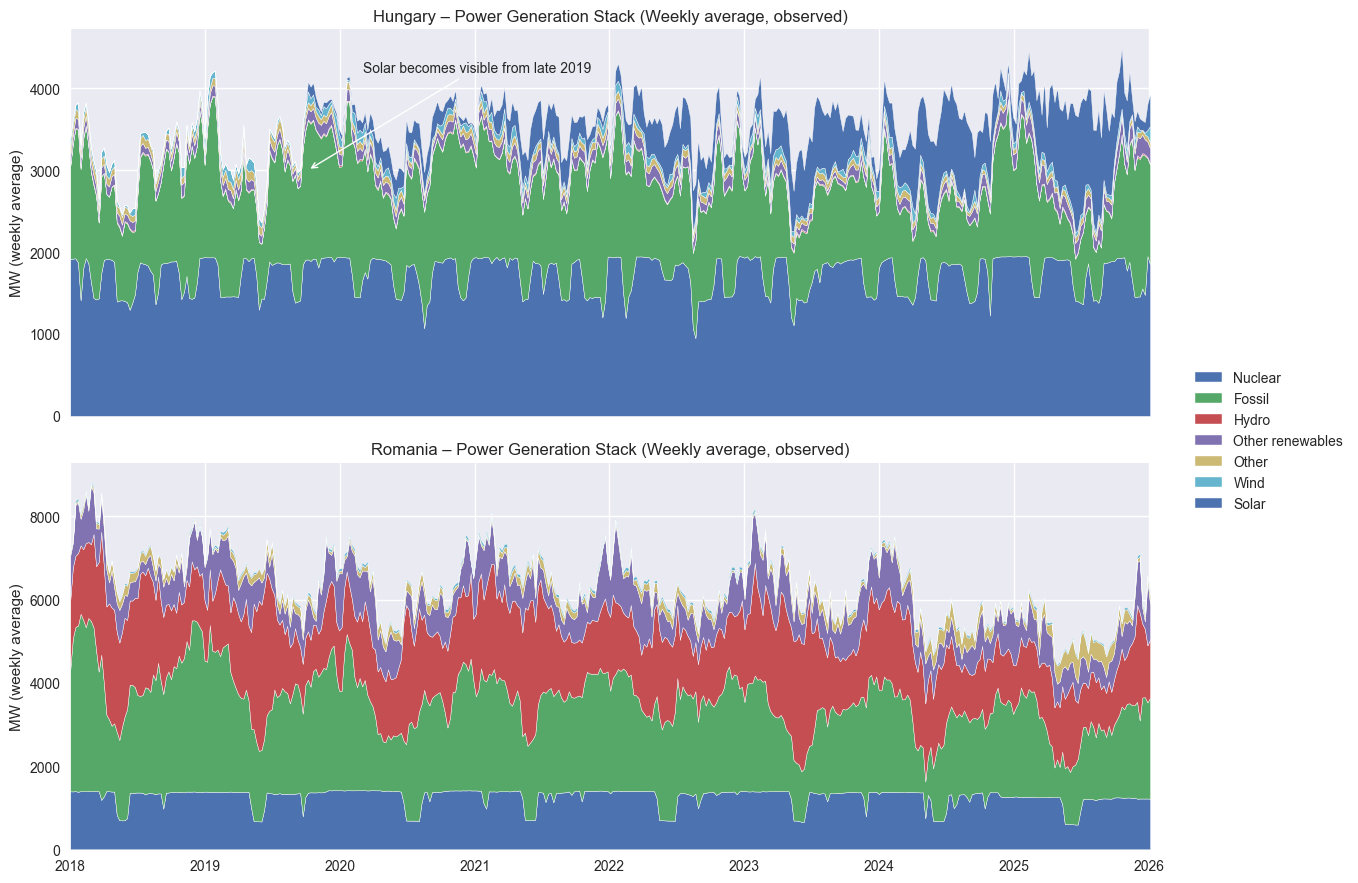

In [ ]:
# --------------------
# Stack orders 
# --------------------
ro_order = ['Nuclear', 'Fossil', 'Hydro', 'Wind', 'Solar', 'Other renewables']
ro_order = [c for c in ro_order if c in romanian_stack.columns]

hu_order = ['Nuclear', 'Fossil', 'Hydro', 'Other renewables','Other', 'Wind', 'Solar']
hu_order = [c for c in hu_order if c in hungarian_stack.columns]


fig, axes = plt.subplots(
    nrows=2, ncols=1,
    figsize=(14, 9),
    sharex=True
)

# --------------------
# Hungary 
# --------------------
axes[0].stackplot(
    hungarian_stack.index,
    [hungarian_stack[c].values for c in hu_order],
    labels=hu_order
)

axes[0].set_title("Hungary – Power Generation Stack (Weekly average, observed)")
axes[0].set_ylabel("MW (weekly average)")
axes[0].margins(x=0)
x = hungarian_stack.index[hungarian_stack.index >= "2019-10-01"][0]
axes[0].annotate(
    "Solar becomes visible from late 2019",
    xy=(x, 3000),
    xytext=(x + pd.Timedelta(days=150), 4200),
    arrowprops=dict(arrowstyle="->", lw=1),
    fontsize=10
)

# --------------------
# Romania 
# --------------------
axes[1].stackplot(
    romanian_stack.index,
    [romanian_stack[c].values for c in ro_order],
    labels=ro_order
)

axes[1].set_title("Romania – Power Generation Stack (Weekly average, observed)")
axes[1].set_ylabel("MW (weekly average)")
axes[1].margins(x=0)

# --------------------
# Legend
# --------------------
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="center left",
    bbox_to_anchor=(0.85, 0.5),
    frameon=False
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


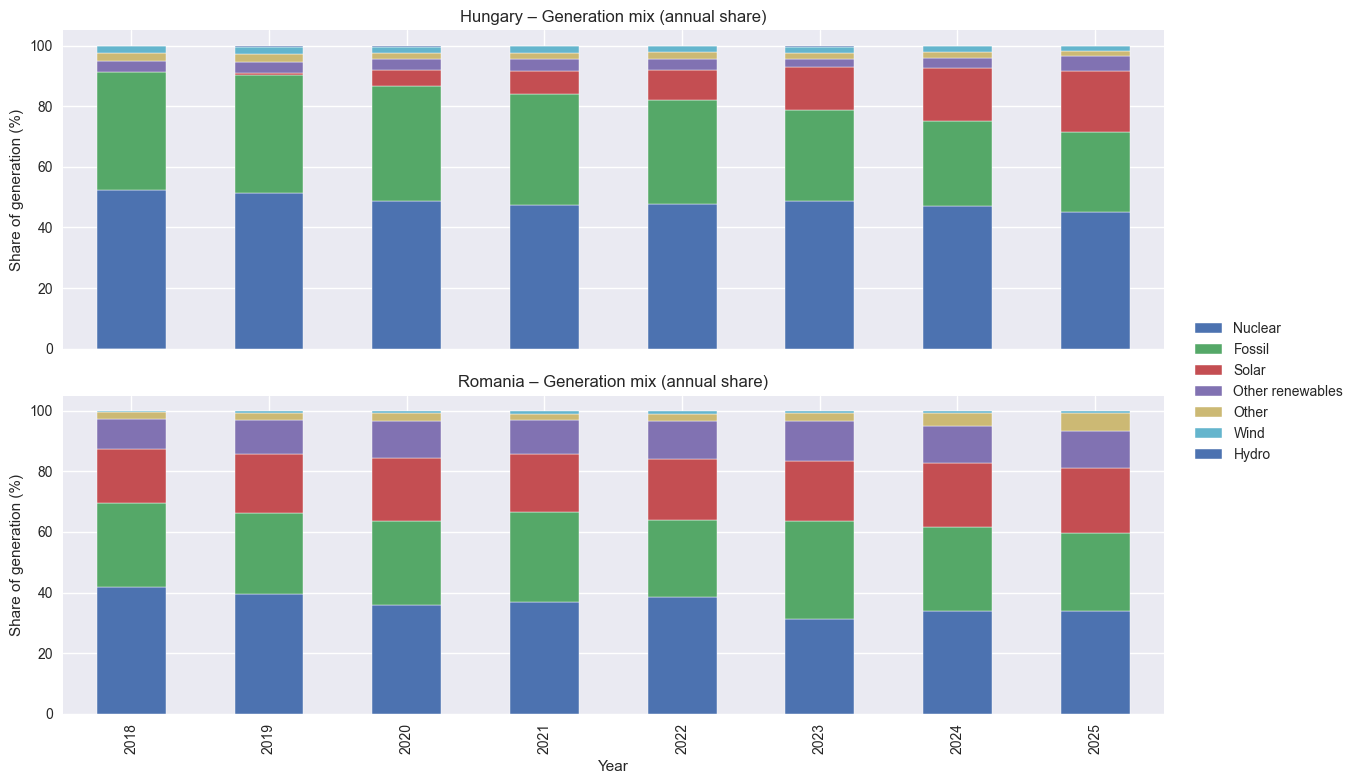

In [175]:
# Other visualization for question 2

def plot_stack_share_2021_2025(stack_df, title, ax):
    # Annual average (yearly)
    yearly = stack_df.resample("YE").mean()
    yearly.index = yearly.index.year

    yearly = yearly.loc[2018:2025]

    # Convert to % share
    share = yearly.div(yearly.sum(axis=1), axis=0) * 100

    # Order by average share (biggest at bottom)
    order = share.mean().sort_values(ascending=False).index.tolist()

    share[order].plot(kind="bar", stacked=True, ax=ax, legend=False)
    ax.set_title(title)
    ax.set_ylabel("Share of generation (%)")
    ax.set_xlabel("Year")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

plot_stack_share_2021_2025(hungarian_stack, "Hungary – Generation mix (annual share)", axes[0])
plot_stack_share_2021_2025(romanian_stack, "Romania – Generation mix (annual share)", axes[1])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(0.85, 0.5), frameon=False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


##### 2. Reconstruct the average Load (demand) in Romania for each day of the week (Monday to Sunday) and hour (0 to 23) on 2024 data only. What observations can you make? (if you wish you can switch the data to another time zone more representative for Romania).

In [178]:
# Prepare hourly load data for Romania in 2024
romania_load_hourly = romanian_data[["ro_total_load_MW_obs"]].copy()
romania_load_hourly.index = (
    romania_load_hourly.index
    .tz_convert("Europe/Bucharest")
)

romania_load_2024_hourly = romania_load_hourly.loc[
    "2024-01-01":"2024-12-31"
].copy()

In [179]:
# Add day of week and hour of day columns and compute averages
romania_load_2024_hourly["day_of_week"] = (
    romania_load_2024_hourly.index.day_name()
)
romania_load_2024_hourly["hour_of_day"] = (
    romania_load_2024_hourly.index.hour
)

romania_average_load_by_day_hour_2024 = (
    romania_load_2024_hourly
    .groupby(["day_of_week", "hour_of_day"])["ro_total_load_MW_obs"]
    .mean()
    .unstack("hour_of_day")
)


In [180]:
# Reorder days of the week and round values
weekday_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

romania_average_load_by_day_hour_2024 = (
    romania_average_load_by_day_hour_2024
    .reindex(weekday_order)
)

romania_average_load_by_day_hour_2024 = (
    romania_average_load_by_day_hour_2024.round(0)
)

In [181]:
romania_average_load_by_day_hour_2024

hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
Monday,5267.0,5071.0,4969.0,4928.0,4978.0,5171.0,5712.0,6418.0,6798.0,6795.0,...,6388.0,6465.0,6659.0,6956.0,7221.0,7388.0,7423.0,7214.0,6669.0,6131.0
Tuesday,5757.0,5545.0,5416.0,5366.0,5406.0,5564.0,5992.0,6620.0,6950.0,6900.0,...,6457.0,6531.0,6726.0,7018.0,7262.0,7420.0,7440.0,7232.0,6696.0,6164.0
Wednesday,5798.0,5582.0,5457.0,5411.0,5445.0,5598.0,6024.0,6657.0,6980.0,6957.0,...,6494.0,6561.0,6756.0,7036.0,7276.0,7442.0,7478.0,7266.0,6718.0,6186.0
Thursday,5820.0,5606.0,5477.0,5426.0,5467.0,5612.0,6037.0,6652.0,6971.0,6933.0,...,6443.0,6515.0,6702.0,6987.0,7237.0,7416.0,7445.0,7248.0,6707.0,6177.0
Friday,5819.0,5601.0,5471.0,5423.0,5455.0,5602.0,6005.0,6597.0,6888.0,6840.0,...,6373.0,6430.0,6638.0,6931.0,7164.0,7331.0,7357.0,7168.0,6662.0,6160.0
Saturday,5792.0,5555.0,5407.0,5331.0,5333.0,5361.0,5445.0,5667.0,5872.0,5894.0,...,5565.0,5663.0,5932.0,6299.0,6597.0,6794.0,6835.0,6699.0,6277.0,5814.0
Sunday,5453.0,5219.0,5078.0,5003.0,4976.0,4984.0,5018.0,5107.0,5181.0,5130.0,...,4920.0,5066.0,5366.0,5758.0,6073.0,6342.0,6446.0,6365.0,5989.0,5582.0


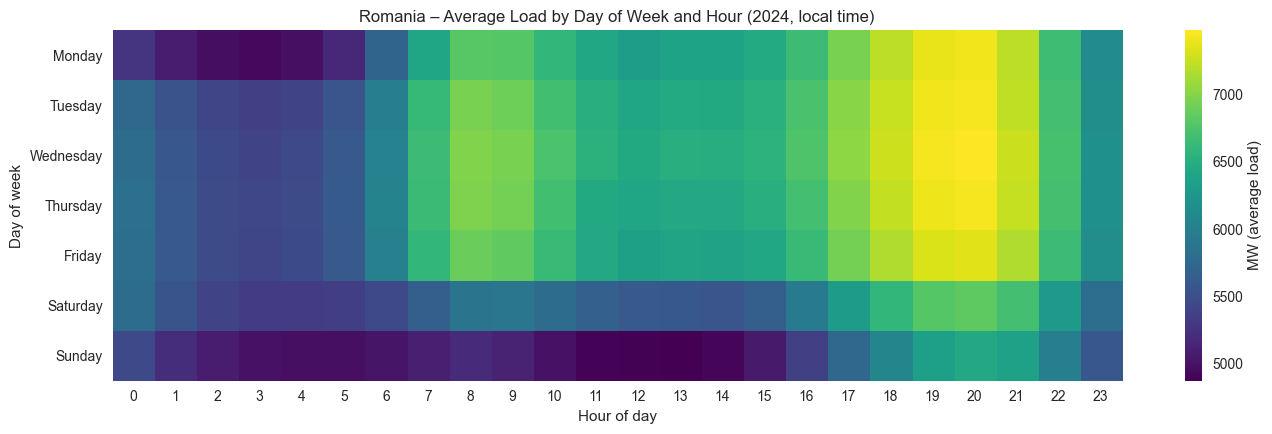

In [265]:
# Heatmap visualization for Romania average load by day of week and hour in 2024
heatmap_df = romania_average_load_by_day_hour_2024.copy()

fig, ax = plt.subplots(figsize=(14, 4.5))

im = ax.imshow(
    heatmap_df.values,
    aspect="auto",
    interpolation="none",
    cmap="viridis"
)

ax.set_title("Romania – Average Load by Day of Week and Hour (2024, local time)")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Day of week")

ax.set_xticks(np.arange(24))
ax.set_xticklabels([str(h) for h in range(24)])

ax.set_yticks(np.arange(len(heatmap_df.index)))
ax.set_yticklabels(heatmap_df.index)
ax.grid(False)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("MW (average load)")

plt.tight_layout()
plt.show()


#### 3) Compute a forecast for the Romanian Day Ahead price for year 2025 and back-test your model on the observed data. Please support your work with adequate data visualization and some comments about the performances/results of your model.

In [183]:
# Data exploration and preprocessing done in this notebook but model training and evaluation in model.ipynb

In [184]:
skim(data_other)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 52608  │ │ float64     │ 7     │                                                          │
│ │ Number of columns │ 8      │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column     ┃ NA    ┃ NA %       ┃ mean    ┃ sd       ┃ p0     ┃ p25   ┃ p50   ┃ p75   ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ natural_ga │ 50416 │ 95.8333333 │ 1959000 │ 91740000 │  4.428 │ 26.66 │ 36.48 │ 51.81 │ 429500000 │   █    │  │
│ │ s_price_eu │       │    3333333 │         │          │        │       │       │       │         0 │        │  │
│ │ ro_mwh_obs │       │            │         │          │        │       │       │       │           │        │  │
│ │ coal_price │ 51093 │ 97.1202098 │   17.53 │    11.79 │   4.88 │ 11.32 │ 14.75 │ 18.28 │     59.28 │ █▇▁▁▁▁ │  │
│ │ _euro_mwh_ │       │     540146 │         │          │        │       │       │       │           │        │  │
│ │ obs        │       │            │         │          │        │       │       │       │           │        │  │
│ │ co2_price_ │ 51072 │ 97.0802919 │   63.58 │    21.38 │  15.23 │ 52.89 │ 69.36 │ 80.25 │     97.58 │ ▄▂▂▇█▄ │  │
│ │ euro_t_obs │       │    7080292 │         │          │        │       │       │       │           │        │  │
│ │ ro_coal_ca │     6 │ 0.01140510 │   961.3 │    270.5 │      0 │   938 │  1023 │  1133 │      1133 │ ▁   ▄█ │  │
│ │ pa_availab │       │ 9489051095 │         │          │        │       │       │       │           │        │  │
│ │ le_MW_obs  │       │            │         │          │        │       │       │       │           │        │  │
│ │ ro_gas_cap │     6 │ 0.01140510 │    2830 │    362.2 │   1451 │  2626 │  2889 │  3083 │      3453 │  ▁▁▄█▄ │  │
│ │ a_availabl │       │ 9489051095 │         │          │        │       │       │       │           │        │  │
│ │ e_MW_obs   │       │            │         │          │        │       │       │       │           │        │  │
│ │ ro_day_ahe │     0 │          0 │   121.9 │    106.8 │ -106.4 │ 53.69 │ 95.98 │ 148.6 │      1022 │  ▆█▁   │  │
│ │ ad_price_e │       │            │         │          │        │       │       │       │           │        │  │
│ │ uro_mwh_ob │       │            │         │          │        │       │       │       │           │        │  │
│ │ s          │       │            │         │          │        │       │       │       │           │        │  │
│ │ ro_nuclear │  3670 │ 6.97612530 │    1196 │    233.3 │    481 │  1300 │  1300 │  1300 │      1310 │  ▁   █ │  │
│ │ _capa_avai │       │    4136253 │         │          │        │       │       │       │           │        │  │
│ │ lable_MW_o │       │            │         │          │        │       │       │       │           │        │  │
│ │ bs         │       │            │         │          │        │       │       │       │           │        │  │
│ └────────────┴───────┴────────────┴─────────┴─────────

In [185]:
data_other.columns

Index(['Unnamed: 0', 'natural_gas_price_euro_mwh_obs',
       'coal_price_euro_mwh_obs', 'co2_price_euro_t_obs',
       'ro_coal_capa_available_MW_obs', 'ro_gas_capa_available_MW_obs',
       'ro_day_ahead_price_euro_mwh_obs', 'ro_nuclear_capa_available_MW_obs'],
      dtype='object')

In [186]:
data_other.rename(columns={"Unnamed: 0": "Timestamp"}, inplace=True)

In [187]:
data_other = data_other.set_index("Timestamp")

In [188]:
data_other.index = pd.to_datetime(data_other.index, utc=True)

In [189]:
data_other.head()

,natural_gas_price_euro_mwh_obs,coal_price_euro_mwh_obs,co2_price_euro_t_obs,ro_coal_capa_available_MW_obs,ro_gas_capa_available_MW_obs,ro_day_ahead_price_euro_mwh_obs,ro_nuclear_capa_available_MW_obs
Timestamp,,,,,,,
2020-01-01 00:00:00+00:00,12.438,NaN,NaN,938.0,3259.1,30.40,NaN
2020-01-01 01:00:00+00:00,NaN,NaN,NaN,938.0,3259.1,28.53,NaN
2020-01-01 02:00:00+00:00,NaN,NaN,NaN,938.0,3259.1,27.37,NaN
2020-01-01 03:00:00+00:00,NaN,NaN,NaN,938.0,3259.1,26.38,NaN
2020-01-01 04:00:00+00:00,NaN,NaN,NaN,938.0,3259.1,26.50,NaN


In [190]:
# Find last NaN for selected columns
cols_to_check = [
    "natural_gas_price_euro_mwh_obs",
    "coal_price_euro_mwh_obs",
    "co2_price_euro_t_obs",
    "ro_nuclear_capa_available_MW_obs",
    "ro_coal_capa_available_MW_obs",
    "ro_gas_capa_available_MW_obs"
]

last_nan_summary = {
    col: data_other[data_other[col].isna()].index.max()
    for col in cols_to_check
}

last_nan_df = pd.DataFrame.from_dict(
    last_nan_summary,
    orient="index",
    columns=["last_nan_date"]
)

last_nan_df

,last_nan_date
natural_gas_price_euro_mwh_obs,2025-12-31 23:00:00+00:00
coal_price_euro_mwh_obs,2025-12-31 23:00:00+00:00
co2_price_euro_t_obs,2025-12-31 23:00:00+00:00
ro_nuclear_capa_available_MW_obs,2020-06-01 21:00:00+00:00
ro_coal_capa_available_MW_obs,2025-03-30 02:00:00+00:00
ro_gas_capa_available_MW_obs,2025-03-30 02:00:00+00:00


In [191]:
data_price = data_other.copy()

In [192]:
data_price.columns = data_price.columns.str.replace("_obs", "", regex=False)

In [193]:
daily_price_cols = [
    "natural_gas_price_euro_mwh",
    "coal_price_euro_mwh",
    "co2_price_euro_t"
]

data_price[daily_price_cols] = data_price[daily_price_cols].ffill()


In [194]:
data_price = data_price.loc["2021-01-01":]

In [195]:
data_price[daily_price_cols].isna().sum()

natural_gas_price_euro_mwh    0
coal_price_euro_mwh           0
co2_price_euro_t              0
dtype: int64

In [196]:
skim(data_price)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 43824  │ │ float64     │ 7     │                                                          │
│ │ Number of columns │ 7      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column     ┃ NA ┃ NA %        ┃ mean    ┃ sd        ┃ p0     ┃ p25   ┃ p50   ┃ p75   ┃ p100       ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ natural_ga │  0 │           0 │ 2352000 │ 100500000 │  15.94 │ 33.34 │ 39.67 │    66 │ 4295000000 │   █    │  │
│ │ s_price_eu │    │             │         │           │        │       │       │       │            │        │  │
│ │ ro_mwh     │    │             │         │           │        │       │       │       │            │        │  │
│ │ coal_price │  0 │           0 │    19.8 │     11.64 │  7.336 │ 12.93 │ 15.57 │ 19.72 │      59.28 │ █▄▁▁▁▁ │  │
│ │ _euro_mwh  │    │             │         │           │        │       │       │       │            │        │  │
│ │ co2_price_ │  0 │           0 │   71.36 │      13.6 │  31.53 │ 64.17 │ 72.13 │ 81.79 │      97.58 │ ▁▁▄██▃ │  │
│ │ euro_t     │    │             │         │           │        │       │       │       │            │        │  │
│ │ ro_coal_ca │  5 │ 0.011409273 │   947.8 │     290.7 │      0 │   938 │  1000 │  1133 │       1133 │ ▁   ▄█ │  │
│ │ pa_availab │    │   457466229 │         │           │        │       │       │       │            │        │  │
│ │ le_MW      │    │             │         │           │        │       │       │       │            │        │  │
│ │ ro_gas_cap │  5 │ 0.011409273 │    2848 │     369.2 │   1732 │  2626 │  2898 │  3087 │       3453 │ ▁▂▁▅█▅ │  │
│ │ a_availabl │    │   457466229 │         │           │        │       │       │       │            │        │  │
│ │ e_MW       │    │             │         │           │        │       │       │       │            │        │  │
│ │ ro_day_ahe │  0 │           0 │   138.4 │     109.6 │ -106.4 │ 75.56 │ 108.5 │ 166.6 │       1022 │  ▄█▁   │  │
│ │ ad_price_e │    │             │         │           │        │       │       │       │            │        │  │
│ │ uro_mwh    │    │             │         │           │        │       │       │       │            │        │  │
│ │ ro_nuclear │  0 │           0 │    1202 │     227.5 │    481 │  1300 │  1300 │  1300 │       1310 │  ▁   █ │  │
│ │ _capa_avai │    │             │         │           │        │       │       │       │            │        │  │
│ │ lable_MW   │    │             │         │           │        │       │       │       │            │        │  │
│ └────────────┴────┴─────────────┴─────────┴───────────┴────────┴───────┴───────┴───────┴────────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [198]:
data_price[data_price["ro_day_ahead_price_euro_mwh"]== 0].head(3)
# We can see that our target variable has some zero values and negative values, which is unusual for electricity prices. 
# This could be due to various factors such as excess or market anomalies.

,natural_gas_price_euro_mwh,coal_price_euro_mwh,co2_price_euro_t,ro_coal_capa_available_MW,ro_gas_capa_available_MW,ro_day_ahead_price_euro_mwh,ro_nuclear_capa_available_MW
Timestamp,,,,,,,
2023-01-01 05:00:00+00:00,66.00,26.210000,80.76,1133.0,3167.4,0.0,1300.0
2023-05-20 11:00:00+00:00,30.66,15.087143,87.76,805.0,2003.4,0.0,650.0
2023-05-20 12:00:00+00:00,30.66,15.087143,87.76,805.0,2003.4,0.0,650.0


In [199]:
# Inspect rows with NaN in coal and gas capacity
data_price[data_price["ro_coal_capa_available_MW"].isna()].head()
# Nearly all NaN values are at the end of March, maybe time change in reporting

,natural_gas_price_euro_mwh,coal_price_euro_mwh,co2_price_euro_t,ro_coal_capa_available_MW,ro_gas_capa_available_MW,ro_day_ahead_price_euro_mwh,ro_nuclear_capa_available_MW
Timestamp,,,,,,,
2021-03-28 02:00:00+00:00,18.999,8.827143,41.63,NaN,NaN,40.31,1300.0
2022-03-27 02:00:00+00:00,94.847,37.481429,78.31,NaN,NaN,97.86,1300.0
2023-03-26 02:00:00+00:00,42.248,17.467143,85.09,NaN,NaN,42.93,1300.0
2024-03-31 02:00:00+00:00,27.132,16.442857,59.98,NaN,NaN,32.31,1300.0
2025-03-30 02:00:00+00:00,42.168,13.291429,67.44,NaN,NaN,1.20,1300.0


In [200]:
capacity_cols = [
    "ro_coal_capa_available_MW",
    "ro_gas_capa_available_MW"
]

data_price[capacity_cols] = data_price[capacity_cols].ffill()

In [202]:
data_price.index.dtype


datetime64[ns, UTC]

In [203]:
data_price.columns

Index(['natural_gas_price_euro_mwh', 'coal_price_euro_mwh', 'co2_price_euro_t',
       'ro_coal_capa_available_MW', 'ro_gas_capa_available_MW',
       'ro_day_ahead_price_euro_mwh', 'ro_nuclear_capa_available_MW'],
      dtype='object')

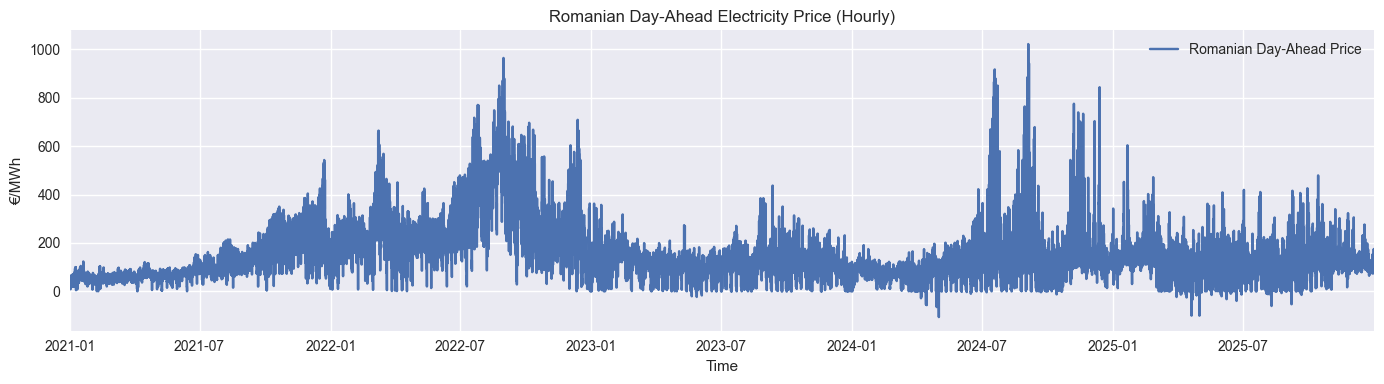

In [204]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(
    data_price.index,
    data_price["ro_day_ahead_price_euro_mwh"],
    label="Romanian Day-Ahead Price"
)

ax.set_title("Romanian Day-Ahead Electricity Price (Hourly)")
ax.set_ylabel("€/MWh")
ax.set_xlabel("Time")
ax.legend(frameon=False)
ax.margins(x=0)

plt.tight_layout()
plt.show()

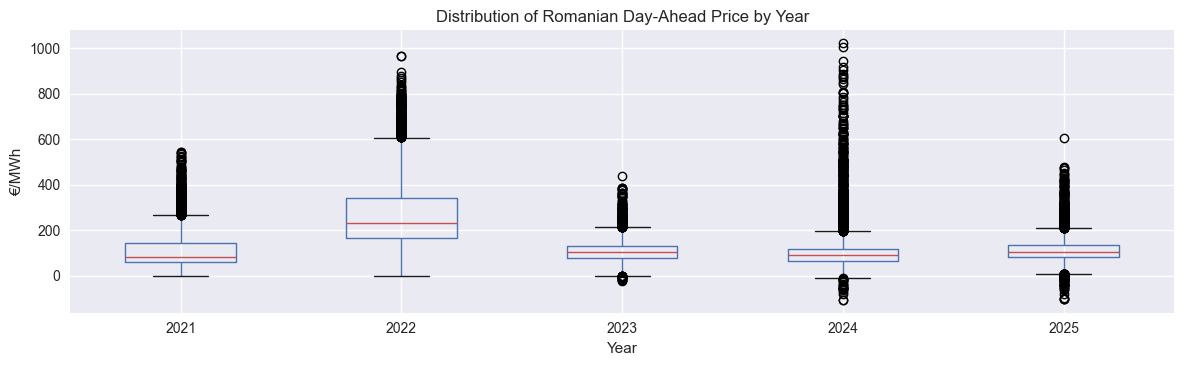

In [205]:
# Boxplot of Romanian Day-Ahead Price by Year
data_price["year"] = data_price.index.year

fig, ax = plt.subplots(figsize=(12, 4))

data_price.boxplot(
    column="ro_day_ahead_price_euro_mwh",
    by="year",
    ax=ax
)

ax.set_title("Distribution of Romanian Day-Ahead Price by Year")
ax.set_ylabel("€/MWh")
ax.set_xlabel("Year")
plt.suptitle("")  # remove automatic pandas title

plt.tight_layout()
plt.savefig('../plot/boxplot_year.png', dpi=300, bbox_inches='tight')
plt.show()




SUMMARY
    Feature  Median Variation (€/MWh)  Relative Variation (%)       p-value
       hour                    85.005               76.095593  0.000000e+00
      month                    53.715               49.195802  0.000000e+00
day_of_week                    29.040               26.677691 2.833241e-281


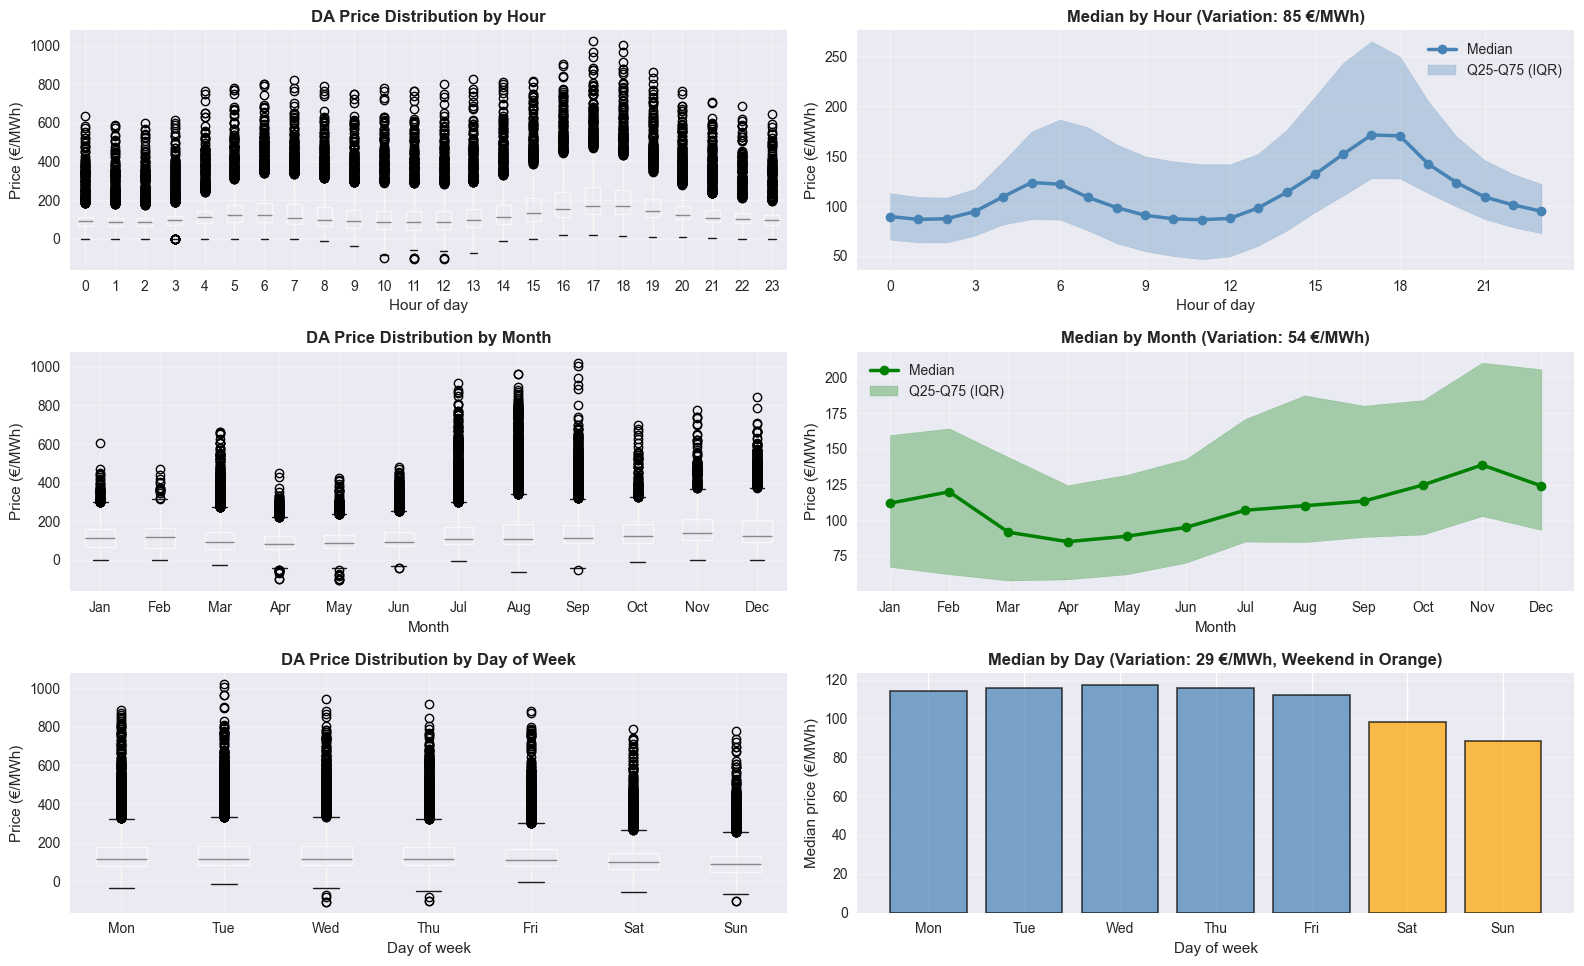

Analysis complete. Visualization saved as 'temporal_features_analysis.png'


In [206]:
# ============================================================
# TEMPORAL FEATURES ANALYSIS
# Analysis of hour, month, and day_of_week impact on DA price
# ============================================================

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================
# DATA PREPARATION
# ============================================================

# Extract temporal features from datetime index
data_price['hour'] = data_price.index.hour
data_price['day_of_week'] = data_price.index.dayofweek  # 0=Monday, 6=Sunday
data_price['month'] = data_price.index.month
data_price['is_weekend'] = data_price['day_of_week'].isin([5, 6]).astype(int)

# ============================================================
# STATISTICAL ANALYSIS 
# ============================================================

# Test ANOVA helps to understand if the means of different groups are significantly different.
# And to know which temporal features have the most impact on price variations.

def analyze_temporal_feature(data, feature_name, feature_col, group_labels=None):
    """
    Analyze the impact of a temporal feature on DA price
    
    Parameters:
    -----------
    data : DataFrame
    feature_name : str (for display)
    feature_col : str (column name)
    group_labels : list (optional, for display)
    """
    
    # Statistics by group
    stats_df = data.groupby(feature_col)['ro_day_ahead_price_euro_mwh'].agg([
        'count', 'mean', 'median', 'std',
        ('q25', lambda x: x.quantile(0.25)),
        ('q75', lambda x: x.quantile(0.75))
    ])
    
    # Add labels if provided
    if group_labels is not None:
        stats_df['label'] = group_labels
    
    # Median variation
    median_var = stats_df['median'].max() - stats_df['median'].min()
    median_mean = stats_df['median'].mean()
    relative_var = 100 * median_var / median_mean
    
    # ANOVA test
    groups = [data[data[feature_col] == val]['ro_day_ahead_price_euro_mwh'] 
              for val in stats_df.index]
    f_stat, p_value = stats.f_oneway(*groups)
    
    return {
        'stats': stats_df,
        'median_variation': median_var,
        'relative_variation': relative_var,
        'f_stat': f_stat,
        'p_value': p_value
    }

# Analyze all three features

# HOUR, MONTH, DAY OF WEEK
hour_results = analyze_temporal_feature(data_price, 'Hour', 'hour')
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_results = analyze_temporal_feature(data_price, 'Month', 'month', month_labels)
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_results = analyze_temporal_feature(data_price, 'Day of Week', 'day_of_week', dow_labels)

# Weekend effect
weekend_stats = data_price.groupby('is_weekend')['ro_day_ahead_price_euro_mwh'].median()
weekend_diff = weekend_stats[1] - weekend_stats[0]

# Summary table
summary = pd.DataFrame({
    'Feature': ['hour', 'month', 'day_of_week'],
    'Median Variation (€/MWh)': [
        hour_results['median_variation'],
        month_results['median_variation'],
        dow_results['median_variation']
    ],
    'Relative Variation (%)': [
        hour_results['relative_variation'],
        month_results['relative_variation'],
        dow_results['relative_variation']
    ],
    'p-value': [
        hour_results['p_value'],
        month_results['p_value'],
        dow_results['p_value']
    ]
}).sort_values('Median Variation (€/MWh)', ascending=False)

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(summary.to_string(index=False))

# =================
# VISUALIZATIONS 
# =================

fig = plt.figure(figsize=(16, 10))

# Color palettes
hour_color = 'steelblue'
month_color = 'green'
dow_colors = ['steelblue']*5 + ['orange']*2  # Weekend in orange

# ------
# HOUR 
# -------

# Hour - Boxplot
ax1 = plt.subplot(3, 2, 1)
data_price.boxplot(column='ro_day_ahead_price_euro_mwh', by='hour', ax=ax1)
ax1.set_title("DA Price Distribution by Hour", fontweight='bold', fontsize=12)
ax1.set_xlabel("Hour of day")
ax1.set_ylabel("Price (€/MWh)")
ax1.get_figure().suptitle("")
ax1.grid(True, alpha=0.3)

# Hour - Median + IQR
ax2 = plt.subplot(3, 2, 2)
x_hours = hour_results['stats'].index
ax2.plot(x_hours, hour_results['stats']['median'], marker='o', linewidth=2.5, 
         color=hour_color, label='Median')
ax2.fill_between(x_hours, 
                  hour_results['stats']['q25'], 
                  hour_results['stats']['q75'], 
                  alpha=0.3, color=hour_color, label='Q25-Q75 (IQR)')
ax2.set_title(f"Median by Hour (Variation: {hour_results['median_variation']:.0f} €/MWh)", 
              fontweight='bold', fontsize=12)
ax2.set_xlabel("Hour of day")
ax2.set_ylabel("Price (€/MWh)")
ax2.set_xticks(range(0, 24, 3))
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

# ----------
# MONTH 
# ----------

# Month - Boxplot
ax3 = plt.subplot(3, 2, 3)
data_price.boxplot(column='ro_day_ahead_price_euro_mwh', by='month', ax=ax3)
ax3.set_title("DA Price Distribution by Month", fontweight='bold', fontsize=12)
ax3.set_xlabel("Month")
ax3.set_ylabel("Price (€/MWh)")
ax3.set_xticklabels(month_labels)
ax3.get_figure().suptitle("")
ax3.grid(True, alpha=0.3)

# Month - Median + IQR
ax4 = plt.subplot(3, 2, 4)
x_months = month_results['stats'].index
ax4.plot(x_months, month_results['stats']['median'], marker='o', linewidth=2.5, 
         color=month_color, label='Median')
ax4.fill_between(x_months, 
                  month_results['stats']['q25'], 
                  month_results['stats']['q75'], 
                  alpha=0.3, color=month_color, label='Q25-Q75 (IQR)')
ax4.set_title(f"Median by Month (Variation: {month_results['median_variation']:.0f} €/MWh)", 
              fontweight='bold', fontsize=12)
ax4.set_xlabel("Month")
ax4.set_ylabel("Price (€/MWh)")
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(month_labels)
ax4.legend(loc='best', fontsize=10)
ax4.grid(True, alpha=0.3)

# --------------
# DAY OF WEEK 
# --------------

# Day of week - Boxplot
ax5 = plt.subplot(3, 2, 5)
data_price.boxplot(column='ro_day_ahead_price_euro_mwh', by='day_of_week', ax=ax5)
ax5.set_title("DA Price Distribution by Day of Week", fontweight='bold', fontsize=12)
ax5.set_xlabel("Day of week")
ax5.set_ylabel("Price (€/MWh)")
ax5.set_xticklabels(dow_labels)
ax5.get_figure().suptitle("")
ax5.grid(True, alpha=0.3)

# Day of week - Median (bar chart with weekend highlighted)
ax6 = plt.subplot(3, 2, 6)
x_days = dow_results['stats'].index
ax6.bar(x_days, dow_results['stats']['median'], color=dow_colors, 
        alpha=0.7, edgecolor='black', linewidth=1.2)
ax6.set_title(f"Median by Day (Variation: {dow_results['median_variation']:.0f} €/MWh, Weekend in Orange)", 
              fontweight='bold', fontsize=12)
ax6.set_xlabel("Day of week")
ax6.set_ylabel("Median price (€/MWh)")
ax6.set_xticks(range(7))
ax6.set_xticklabels(dow_labels)
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../plot/temporal_features_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Analysis complete. Visualization saved as 'temporal_features_analysis.png'")


In [207]:
data_price.head()

,natural_gas_price_euro_mwh,coal_price_euro_mwh,co2_price_euro_t,ro_coal_capa_available_MW,ro_gas_capa_available_MW,ro_day_ahead_price_euro_mwh,ro_nuclear_capa_available_MW,year,hour,day_of_week,month,is_weekend
Timestamp,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,16.954,7.95,32.04,1133.0,2420.4,41.59,1300.0,2021,0,4,1,0
2021-01-01 01:00:00+00:00,16.954,7.95,32.04,1133.0,2420.4,40.05,1300.0,2021,1,4,1,0
2021-01-01 02:00:00+00:00,16.954,7.95,32.04,1133.0,2420.4,36.90,1300.0,2021,2,4,1,0
2021-01-01 03:00:00+00:00,16.954,7.95,32.04,1133.0,2420.4,34.47,1300.0,2021,3,4,1,0
2021-01-01 04:00:00+00:00,16.954,7.95,32.04,1133.0,2420.4,32.82,1300.0,2021,4,4,1,0


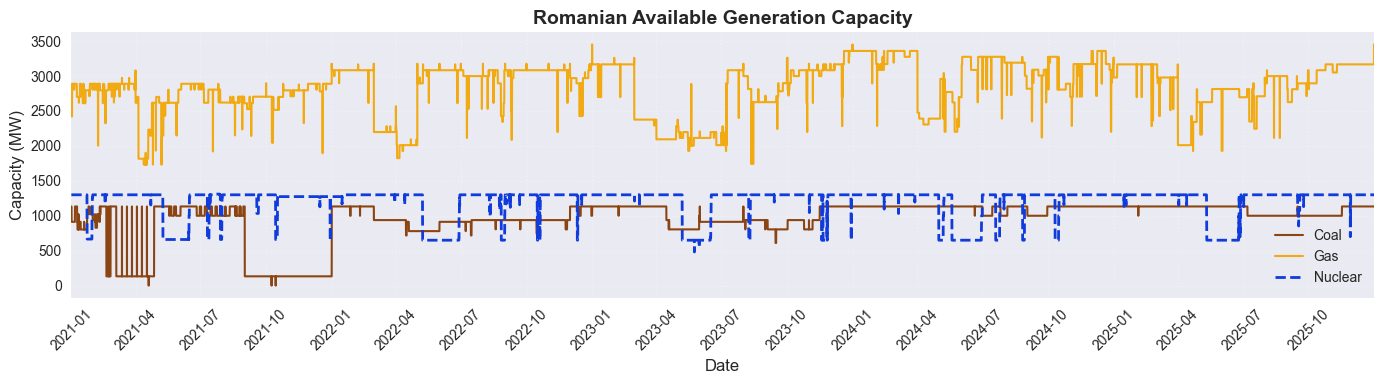

In [208]:
# Plot available generation capacities over time
fig, ax = plt.subplots(figsize=(14, 4))

# Plot des capacités
ax.plot(data_price.index, data_price["ro_coal_capa_available_MW"], 
        label="Coal", linewidth=1.5, color='#8B4513')
ax.plot(data_price.index, data_price["ro_gas_capa_available_MW"], 
        label="Gas", linewidth=1.5, color="#F1AA12")
ax.plot(data_price.index, data_price["ro_nuclear_capa_available_MW"], 
        label="Nuclear", linestyle="--", linewidth=2, color="#103CDB")

# Format x-axis for better readability
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

ax.set_title("Romanian Available Generation Capacity", fontsize=14, fontweight='bold')
ax.set_ylabel("Capacity (MW)", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.legend(frameon=False, loc='best')
ax.grid(True, alpha=0.3, linestyle=':')
ax.margins(x=0)

plt.tight_layout()
plt.show()

In [209]:
# Feature engineering on data_price for modeling

In [210]:
skim(data_price)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 43824  │ │ float64     │ 7     │                                                          │
│ │ Number of columns │ 12     │ │ int64       │ 5     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column            ┃ NA ┃ NA % ┃ mean    ┃ sd        ┃ p0     ┃ p25   ┃ p50   ┃ p75   ┃ p100       ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ natural_gas_price │  0 │    0 │ 2352000 │ 100500000 │  15.94 │ 33.34 │ 39.67 │    66 │ 4295000000 │   █    │  │
│ │ _euro_mwh         │    │      │         │           │        │       │       │       │            │        │  │
│ │ coal_price_euro_m │  0 │    0 │    19.8 │     11.64 │  7.336 │ 12.93 │ 15.57 │ 19.72 │      59.28 │ █▄▁▁▁▁ │  │
│ │ wh                │    │      │         │           │        │       │       │       │            │        │  │
│ │ co2_price_euro_t  │  0 │    0 │   71.36 │      13.6 │  31.53 │ 64.17 │ 72.13 │ 81.79 │      97.58 │ ▁▁▄██▃ │  │
│ │ ro_coal_capa_avai │  0 │    0 │   947.8 │     290.7 │      0 │   938 │  1000 │  1133 │       1133 │ ▁   ▄█ │  │
│ │ lable_MW          │    │      │         │           │        │       │       │       │            │        │  │
│ │ ro_gas_capa_avail │  0 │    0 │    2848 │     369.2 │   1732 │  2626 │  2898 │  3087 │       3453 │ ▁▂▁▅█▅ │  │
│ │ able_MW           │    │      │         │           │        │       │       │       │            │        │  │
│ │ ro_day_ahead_pric │  0 │    0 │   138.4 │     109.6 │ -106.4 │ 75.56 │ 108.5 │ 166.6 │       1022 │  ▄█▁   │  │
│ │ e_euro_mwh        │    │      │         │           │        │       │       │       │            │        │  │
│ │ ro_nuclear_capa_a │  0 │    0 │    1202 │     227.5 │    481 │  1300 │  1300 │  1300 │       1310 │  ▁   █ │  │
│ │ vailable_MW       │    │      │         │           │        │       │       │       │            │        │  │
│ │ year              │  0 │    0 │    2023 │     1.414 │   2021 │  2022 │  2023 │  2024 │       2025 │ ██ ███ │  │
│ │ hour              │  0 │    0 │    11.5 │     6.922 │      0 │  5.75 │  11.5 │ 17.25 │         23 │ ██████ │  │
│ │ day_of_week       │  0 │    0 │       3 │     2.001 │      0 │     1 │     3 │     5 │          6 │ ▄▄▄▄▄█ │  │
│ │ month             │  0 │    0 │   6.524 │     3.449 │      1 │     4 │     7 │    10 │         12 │ ██████ │  │
│ │ is_weekend        │  0 │    0 │  0.2859 │    0.4518 │      0 │     0 │     0 │     1 │          1 │ █    ▃ │  │
│ └───────────────────┴────┴──────┴─────────┴───────────┴────────┴───────┴───────┴───────┴────────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [211]:
sns.set(style="whitegrid")


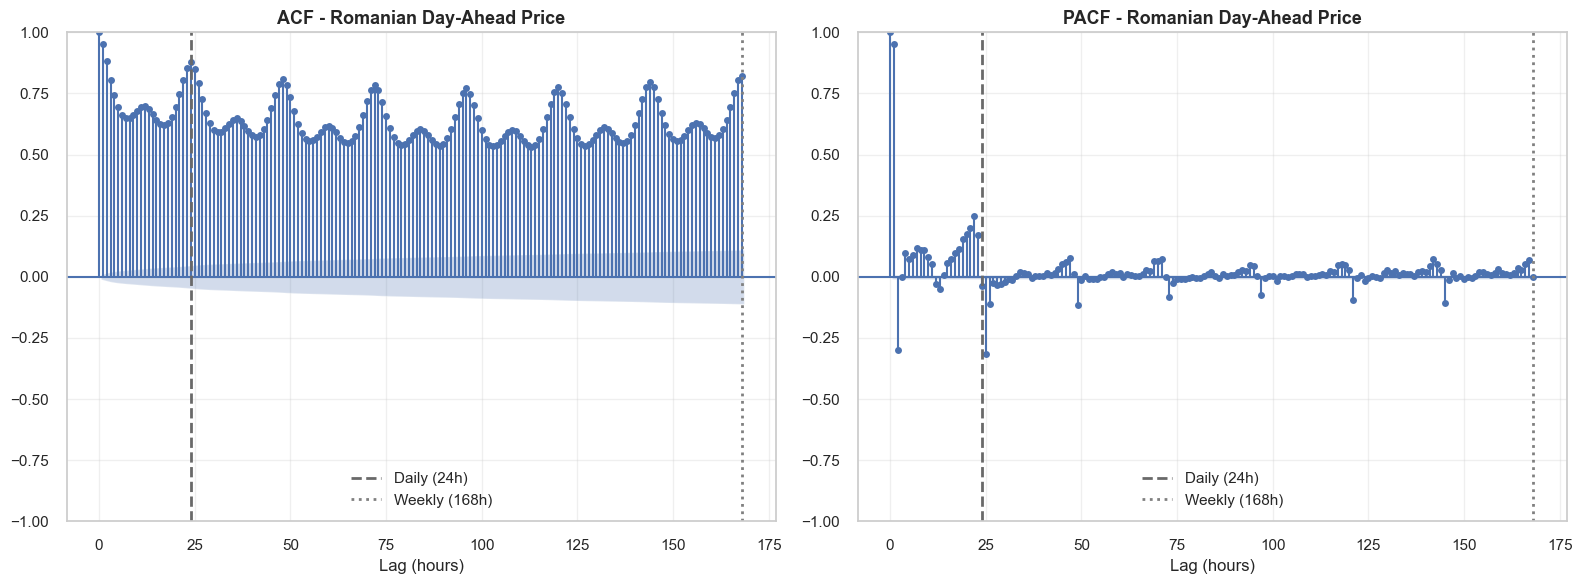

In [212]:
# AUTOCORRELATION ANALYSIS in oder to understand temporal dependencies
series = data_price['ro_day_ahead_price_euro_mwh'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ======================
# ACF
# ======================
plot_acf(
    series,
    lags=168,
    ax=axes[0],
    alpha=0.05
)

axes[0].set_title(
    'ACF - Romanian Day-Ahead Price',
    fontweight='bold',
    fontsize=13
)
axes[0].set_xlabel('Lag (hours)')

axes[0].axvline(
    24, color='dimgray', linestyle='--', linewidth=2, label='Daily (24h)'
)
axes[0].axvline(
    168, color='gray', linestyle=':', linewidth=2, label='Weekly (168h)'
)

axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ======================
# PACF
# ======================
plot_pacf(
    series,
    lags=168,
    ax=axes[1],
    alpha=0.05,
    method='ywm'
)

axes[1].set_title(
    'PACF - Romanian Day-Ahead Price',
    fontweight='bold',
    fontsize=13
)
axes[1].set_xlabel('Lag (hours)')

axes[1].axvline(
    24, color='dimgray', linestyle='--', linewidth=2, label='Daily (24h)'
)
axes[1].axvline(
    168, color='gray', linestyle=':', linewidth=2, label='Weekly (168h)'
)

axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    '../plot/autocorrelation_analysis.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()


In [213]:
### MODELING PREPARATION ###

In [214]:
# Define target variable
TARGET_COL = "ro_day_ahead_price_euro_mwh"
data_price = data_price.rename(columns={TARGET_COL: "target"})

In [215]:
# Create lag features based on autocorrelation analysis
data_price["target_lag_1"]   = data_price["target"].shift(1)
data_price["target_lag_24"]  = data_price["target"].shift(24)
data_price["target_lag_168"] = data_price["target"].shift(168)

In [216]:
# Features 
feature_cols = [
    "hour", "day_of_week", "month",

    "natural_gas_price_euro_mwh",
    "coal_price_euro_mwh",
    "co2_price_euro_t",

    "ro_gas_capa_available_MW",
    "ro_coal_capa_available_MW",
    "ro_nuclear_capa_available_MW",

    "target_lag_24",
    "target_lag_168",
    "target_lag_1"
]

feature_cols = [c for c in feature_cols if c in data_price.columns]

In [217]:
model_df = data_price[feature_cols + ["target"]].copy()

In [218]:
# Drop rows with NaN values (due to lag features)
model_df = model_df.dropna()

In [ ]:
model_df.sort_index(inplace=True)

In [220]:
model_df.columns

Index(['hour', 'day_of_week', 'month', 'natural_gas_price_euro_mwh',
       'coal_price_euro_mwh', 'co2_price_euro_t', 'ro_gas_capa_available_MW',
       'ro_coal_capa_available_MW', 'ro_nuclear_capa_available_MW',
       'target_lag_24', 'target_lag_168', 'target_lag_1', 'target'],
      dtype='object')

In [221]:
#model_df.to_csv("../data/processed_data/data_modeling_da_price.csv", index=True)

In [ ]:
# Add ro_total_load_MW_obs to Romanian 
romanian_data = pd.read_csv("../data/processed_data/romanian_data.csv",
    parse_dates=["Timestamp"]
)

romanian_data = romanian_data.set_index("Timestamp")

In [223]:
romanian_data = romanian_data.loc["2021-01-08":]

In [224]:
romanian_data["ro_total_load_MW_obs"].isna().sum()

np.int64(1437)

In [225]:
# Filling missing values in 'ro_total_load_MW_obs' using average load profiles
col = "ro_total_load_MW_obs"

month = romanian_data.index.month
weekday = romanian_data.index.weekday   
hour = romanian_data.index.hour        

# Build an average load profile by (month, weekday, hour)
profile_m = (
    pd.DataFrame({
        "month": month,
        "weekday": weekday,
        "hour": hour,
        col: romanian_data[col].values
    })
    .groupby(["month", "weekday", "hour"])[col]
    .mean()
)

# Optional fallback profile (weekday, hour) in case some (month,weekday,hour) group is missing
profile_wh = (
    pd.DataFrame({
        "weekday": weekday,
        "hour": hour,
        col: romanian_data[col].values
    })
    .groupby(["weekday", "hour"])[col]
    .mean()
)

# Fill NaNs using the profiles
mask = romanian_data[col].isna()

filled = []
for m, wd, hr in zip(month[mask], weekday[mask], hour[mask]):
    key_m = (m, wd, hr)
    key_wh = (wd, hr)

    # Use month-weekday-hour profile if available, otherwise fallback to weekday-hour
    if key_m in profile_m.index and not np.isnan(profile_m.loc[key_m]):
        filled.append(profile_m.loc[key_m])
    else:
        filled.append(profile_wh.loc[key_wh])

romanian_data.loc[mask, col] = filled

print("Number of NaN:", romanian_data[col].isna().sum())

Number of NaN: 0


In [226]:
model_df = model_df.merge(
    romanian_data[["ro_total_load_MW_obs"]],
    left_index=True,
    right_index=True,
    how="left"
)

In [227]:
model_df.columns

Index(['hour', 'day_of_week', 'month', 'natural_gas_price_euro_mwh',
       'coal_price_euro_mwh', 'co2_price_euro_t', 'ro_gas_capa_available_MW',
       'ro_coal_capa_available_MW', 'ro_nuclear_capa_available_MW',
       'target_lag_24', 'target_lag_168', 'target_lag_1', 'target',
       'ro_total_load_MW_obs'],
      dtype='object')

In [228]:
#model_df.to_csv("../data/processed_data/data_modeling_da_price.csv", index=True)

In [229]:
# Try to add one variale from forecast data

In [230]:
wind_fc_raw = pd.read_csv("../data/raw/res_forecasts.csv", sep=";")


In [231]:
# Keep only relevant columns
wind_fc_raw = wind_fc_raw[[
    "Date",
    "ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc"
]].copy()

In [232]:
len(wind_fc_raw)


107850

In [233]:
wind_fc_raw.isna().sum()
rows_without_date = wind_fc_raw.loc[wind_fc_raw["Date"].isna()]
len(rows_without_date), rows_without_date.head()
wind_fc_2021_2025 = wind_fc_raw.loc[
    (wind_fc_raw["Date"] >= "2021-01-01") &
    (wind_fc_raw["Date"] <= "2025-12-31 23:00:00")
].copy()

# Convert to numeric
wind_fc_2021_2025["ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc"] = (
    wind_fc_2021_2025["ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc"]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.strip()
)

wind_fc_2021_2025["ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc"] = pd.to_numeric(
    wind_fc_2021_2025["ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc"],
    errors="coerce"
)

print(wind_fc_2021_2025.dtypes)
print("NaN wind after conversion:",
      wind_fc_2021_2025["ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc"].isna().sum())

wind_fc = wind_fc_2021_2025.rename(columns={
    "Date": "timestamp",
    "ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc": "wind_fc_p50"
}).copy()


Date                                                  object
ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc    float64
dtype: object
NaN wind after conversion: 0


In [234]:
rows_without_date = wind_fc_raw.loc[wind_fc_raw["Date"].isna()]
len(rows_without_date), rows_without_date.head()

(55242,
   Date ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc
 1  NaN                                          1272,559
 3  NaN                                          1349,551
 5  NaN                                          1430,283
 7  NaN                                          1495,245
 9  NaN                                           1565,54)

In [235]:
wind_fc_2021_2025 = wind_fc_raw.loc[
    (wind_fc_raw["Date"] >= "2021-01-01") &
    (wind_fc_raw["Date"] <= "2025-12-31 23:00:00")
].copy()


In [236]:
wind_fc_2021_2025.isna().sum()

Date                                                 0
ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc    0
dtype: int64

In [237]:
# Need to convert to numeric
wind_fc_2021_2025["ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc"] = (
    wind_fc_2021_2025["ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc"]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.strip()
)

wind_fc_2021_2025["ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc"] = pd.to_numeric(
    wind_fc_2021_2025["ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc"],
    errors="coerce"
)

print(wind_fc_2021_2025.dtypes)
print("NaN wind after conversion:",
      wind_fc_2021_2025["ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc"].isna().sum())

Date                                                  object
ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc    float64
dtype: object
NaN wind after conversion: 0


In [238]:
wind_fc = wind_fc_2021_2025.rename(columns={
    "Date": "timestamp",
    "ROU.ECMNDENS.EC.ROU.Pwr.RO.Wind.Percentile.50.utc": "wind_fc_p50"
}).copy()


In [239]:
# To be aligned with hourly data, convert timestamp to datetime with UTC timezone
wind_fc["timestamp"] = pd.to_datetime(wind_fc["timestamp"], utc=True)
wind_fc = wind_fc.set_index("timestamp").sort_index()

In [240]:
print(wind_fc.index.min(), "to", wind_fc.index.max())
print(wind_fc.isna().sum())


2021-01-01 00:00:00+00:00 to 2025-12-31 23:00:00+00:00
wind_fc_p50    0
dtype: int64


In [241]:
model_df = model_df.merge(
    wind_fc[["wind_fc_p50"]],
    left_index=True,
    right_index=True,
    how="left"
)


In [242]:
model_df.columns

Index(['hour', 'day_of_week', 'month', 'natural_gas_price_euro_mwh',
       'coal_price_euro_mwh', 'co2_price_euro_t', 'ro_gas_capa_available_MW',
       'ro_coal_capa_available_MW', 'ro_nuclear_capa_available_MW',
       'target_lag_24', 'target_lag_168', 'target_lag_1', 'target',
       'ro_total_load_MW_obs', 'wind_fc_p50'],
      dtype='object')

In [243]:
model_df.head()

,hour,day_of_week,month,natural_gas_price_euro_mwh,coal_price_euro_mwh,co2_price_euro_t,ro_gas_capa_available_MW,ro_coal_capa_available_MW,ro_nuclear_capa_available_MW,target_lag_24,target_lag_168,target_lag_1,target,ro_total_load_MW_obs,wind_fc_p50
Timestamp,,,,,,,,,,,,,,,
2021-01-08 00:00:00+00:00,0,4,1,18.329,7.914286,34.79,2889.4,1133.0,1300.0,28.03,41.59,44.97,42.92,6126.0,46.531
2021-01-08 01:00:00+00:00,1,4,1,18.329,7.914286,34.79,2889.4,1133.0,1300.0,21.24,40.05,42.92,38.06,6129.0,56.065
2021-01-08 02:00:00+00:00,2,4,1,18.329,7.914286,34.79,2889.4,1133.0,1300.0,22.13,36.90,38.06,37.38,6165.0,71.347
2021-01-08 03:00:00+00:00,3,4,1,18.329,7.914286,34.79,2889.4,1133.0,1300.0,29.17,34.47,37.38,45.28,6362.0,83.595
2021-01-08 04:00:00+00:00,4,4,1,18.329,7.914286,34.79,2889.4,1133.0,1300.0,47.56,32.82,45.28,53.78,6792.0,103.822


In [244]:
model_df["wind_fc_p50"].isna().sum()

np.int64(0)

In [245]:
model_df.shape

(43656, 15)

In [246]:
model_df.to_csv("../data/processed_data/data_da_price.csv", index=True)

In [247]:
solar_fc_raw = pd.read_csv("../data/raw/res_forecasts.csv", sep=";")


In [248]:
# Keep only relevant columns
solar_fc_raw = solar_fc_raw[[
    "Date",
    "ECMNDe.ROU.Solar.PRO.ECMWF.Ens.Percentile.50.utc"
]].copy()

In [249]:
rows_without_date = solar_fc_raw.loc[solar_fc_raw["Date"].isna()]
len(rows_without_date), rows_without_date.head()

(55242,
   Date  ECMNDe.ROU.Solar.PRO.ECMWF.Ens.Percentile.50.utc
 1  NaN                                               0.0
 3  NaN                                               0.0
 5  NaN                                               0.0
 7  NaN                                               0.0
 9  NaN                                               0.0)

In [250]:
solar_fc_raw_fc_2021_2025 = solar_fc_raw.loc[
    (solar_fc_raw["Date"] >= "2021-01-01") &
    (solar_fc_raw["Date"] <= "2025-12-31 23:00:00")
].copy()

In [251]:
# Need to convert to numeric
solar_fc_raw_fc_2021_2025["ECMNDe.ROU.Solar.PRO.ECMWF.Ens.Percentile.50.utc"] = (
    solar_fc_raw_fc_2021_2025["ECMNDe.ROU.Solar.PRO.ECMWF.Ens.Percentile.50.utc"]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.strip()
)

solar_fc_raw_fc_2021_2025["ECMNDe.ROU.Solar.PRO.ECMWF.Ens.Percentile.50.utc"] = pd.to_numeric(
    solar_fc_raw_fc_2021_2025["ECMNDe.ROU.Solar.PRO.ECMWF.Ens.Percentile.50.utc"],
    errors="coerce"
)

print(solar_fc_raw_fc_2021_2025.dtypes)
print("NaN solar after conversion:",
      solar_fc_raw_fc_2021_2025["ECMNDe.ROU.Solar.PRO.ECMWF.Ens.Percentile.50.utc"].isna().sum())

Date                                                 object
ECMNDe.ROU.Solar.PRO.ECMWF.Ens.Percentile.50.utc    float64
dtype: object
NaN solar after conversion: 0


In [252]:
solar_fc_raw_fc = solar_fc_raw_fc_2021_2025.rename(columns={
    "Date": "timestamp",
    "ECMNDe.ROU.Solar.PRO.ECMWF.Ens.Percentile.50.utc": "solar_fc_p50"
}).copy()


In [253]:
# To be aligned with hourly data, convert timestamp to datetime with UTC timezone
solar_fc_raw_fc["timestamp"] = pd.to_datetime(solar_fc_raw_fc["timestamp"], utc=True)
solar_fc_raw_fc = solar_fc_raw_fc.set_index("timestamp").sort_index()

In [254]:
print(solar_fc_raw_fc.index.min(), "to", solar_fc_raw_fc.index.max())
print(solar_fc_raw_fc.isna().sum())

2021-01-01 00:00:00+00:00 to 2025-12-31 23:00:00+00:00
solar_fc_p50    0
dtype: int64


In [255]:
model_df = pd.read_csv("../data/processed_data/data_da_price.csv", index_col="Timestamp", parse_dates=["Timestamp"])

In [256]:
model_df = model_df.merge(
    solar_fc_raw_fc[["solar_fc_p50"]],
    left_index=True,
    right_index=True,
    how="left"
)

In [257]:
model_df.columns

Index(['hour', 'day_of_week', 'month', 'natural_gas_price_euro_mwh',
       'coal_price_euro_mwh', 'co2_price_euro_t', 'ro_gas_capa_available_MW',
       'ro_coal_capa_available_MW', 'ro_nuclear_capa_available_MW',
       'target_lag_24', 'target_lag_168', 'target_lag_1', 'target',
       'ro_total_load_MW_obs', 'wind_fc_p50', 'solar_fc_p50'],
      dtype='object')

In [258]:
model_df["solar_fc_p50"].isna().sum()

np.int64(0)

In [ ]:
model_df.to_csv("../data/processed_data/data_for_modeling.csv", index=True)